# 2D parametric inversion results

This notebook loads the 2D parametric inversion inversion results (Figure 7 in the abstract). The 2D parametric inversion was run using the script [2dinv_parametric.py](2d_inv_parametric/2d_inv_parametric.py)

In [1]:
from SimPEG import EM, Mesh, Utils
import numpy as np
from scipy.constants import mu_0
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from pymatsolver import Pardiso
from SimPEG import Maps
%matplotlib inline

In [2]:
import matplotlib
from matplotlib.colors import LogNorm
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['image.cmap'] = 'viridis'

## Mesh

In [3]:
cs, ncx, ncy, ncz, = 50., 20, 1, 20
npad_x, npad_y, npad_z = 10, 10, 10
pad_rate = 1.3
hx = [(cs,npad_x,-pad_rate), (cs,ncx), (cs,npad_x,pad_rate)]
hy = [(cs,npad_y,-pad_rate), (cs,ncy), (cs,npad_y,pad_rate)]
hz = [(cs,npad_z,-pad_rate), (cs,ncz), (cs,npad_z,pad_rate)]
mesh_3d = Mesh.TensorMesh([hx,hy,hz], 'CCC')
mesh_2d = Mesh.TensorMesh([hx,hz], 'CC')

In [4]:
inds = mesh_2d.vectorCCy<0.
mesh_2d_inv = Mesh.TensorMesh([hx,mesh_2d.hy[inds]], 'CN')
actind = mesh_2d.gridCC[:,1]<0.
map_2Dto3D = Maps.Surject2Dto3D(mesh_3d)
parametric_block = Maps.ParametricBlock(mesh_2d_inv, slope=1e10) #, slopeFact=1
expmap = Maps.ExpMap(mesh_2d)
actmap = Maps.InjectActiveCells(mesh_2d, indActive=actind, valInactive=np.log(1e-8))
mapping = map_2Dto3D* expmap * actmap *  parametric_block 

## Survey

In [5]:
x = mesh_3d.vectorCCx[np.logical_and(mesh_3d.vectorCCx>-450, mesh_3d.vectorCCx<450)]
time = np.logspace(np.log10(5e-5), np.log10(2.5e-3), 21)
srcList = []
ind_start=0
for xloc in x:
    location = np.array([[xloc, 0., 30.]])
    rx_z = EM.TDEM.Rx.Point_dbdt(location, time[ind_start:], 'z')
    rx_x = EM.TDEM.Rx.Point_dbdt(location, time[ind_start:], 'x')
    src = EM.TDEM.Src.CircularLoop([rx_z], orientation='z', loc=location)
    srcList.append(src)
prb = EM.TDEM.Problem3D_e(mesh_3d, sigmaMap=mapping, Solver=Pardiso, verbose=False)
survey = EM.TDEM.Survey(srcList)
prb.timeSteps = [(1e-05, 15), (5e-5, 10), (2e-4, 10)]
survey.pair(prb)    

## Load the results

In [6]:
dobs = np.load('./dobs.npy')
DOBS = dobs.reshape((survey.nSrc, 2, time.size))[:,:,ind_start:]
dobs_dbdtz = DOBS[:, 0, :].flatten()

In [7]:
import os
model = []
for File in sorted(os.listdir("./2d_inv_parametric/")):
    if File.endswith("2018-03-08-20-49.npy"):
        model.append(np.load("./2d_inv_parametric/"+File))  

In [8]:
m = np.load('./2d_inv_parametric/019-InversionModel-2018-03-08-20-49.npy')
results = np.loadtxt('./2d_inv_parametric/InversionModel-2018-03-08-20-49.txt', skiprows=1)
dpred= np.load('./2d_inv_parametric/dpred.npy')
m0 = np.r_[np.log(0.005), np.log(0.05), 0, 150, -150, 100]
sigma_0 = expmap * actmap *  parametric_block  * m0

In [9]:
DPRED = dpred.reshape((survey.nSrc, time.size))[:,ind_start:]

In [10]:
def rect2D(p1, p2):    
    xy = np.c_[np.r_[p1[0], p2[0], p2[0], p1[0], p1[0]], np.r_[p1[1], p1[1], p2[1], p2[1], p1[1]]]
    return xy

In [11]:
blk1 = Utils.ModelBuilder.getIndicesBlock(
    np.r_[-49.5, -50],
    np.r_[50,  -450], 
    mesh_2d.gridCC
)

### Plot the true model

In [12]:
sigma_true = np.ones(mesh_2d.nC)* 1e-3
sigma_true[blk1] = 1e-1

In [13]:
p1 = np.r_[-50, -450]
p2 = np.r_[50, -50]
xy_box = rect2D(p1, p2)

Text(0.5,1,'True')

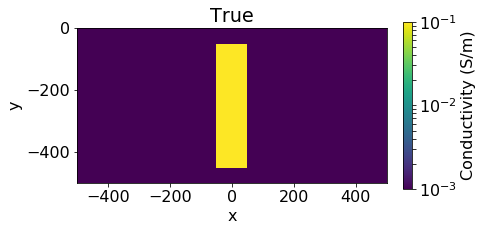

In [17]:
# fig, ax = plt.subplots(1, 1, figsize=(5, 3))

out = mesh_2d.plotImage(sigma_true, pcolorOpts={'norm':LogNorm()}, clim=(1e-3, 1e-1))
cb = plt.colorbar(out[0], fraction=0.025)

# ax.set_ylim(-500, 0.)
plt.gca().set_aspect(1)
plt.xlim(-500, 500)
plt.ylim(-500, 0)
cb.set_label('Conductivity (S/m)')
plt.title("True")

### plot the recovered model

Text(0.5,1,'2D parametric inversion (recovered)')

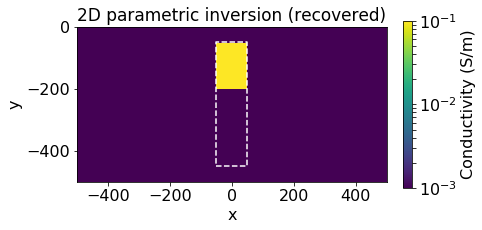

In [18]:
sigma= expmap * actmap *  parametric_block  * m
fig = plt.figure(figsize=(5, 3))
out = mesh_2d.plotImage(sigma, pcolorOpts={'norm':LogNorm()}, clim=(1e-3, 1e-1))
cb = plt.colorbar(out[0], fraction=0.025)
plt.plot(xy_box[:,0], xy_box[:,1], 'w--')
plt.ylim(-500, 0.)
plt.gca().set_aspect(1)
plt.xlim(-500, 500)
plt.ylim(-500, 0)
cb.set_label('Conductivity (S/m)')
plt.title("2D parametric inversion (recovered)", fontsize = 17)

### Plot models as the inversion progressed

In [19]:
def plot_model(iteration):
    sigma= expmap * actmap *  parametric_block  * model[iteration]
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    out = mesh_2d.plotImage(sigma, pcolorOpts={'norm':LogNorm()}, clim=(1e-3, 1e-1), ax=ax)
    cb = plt.colorbar(out[0], fraction=0.025, ax=ax)
    ax.plot(xy_box[:,0], xy_box[:,1], 'w--')
    ax.set_ylim(-500, 0.)
    ax.set_aspect(1)
    ax.set_xlim(-500, 500)
    ax.set_ylim(-500, 0)
    cb.set_label('Conductivity (S/m)')
    ax.set_title(("Iteration %i")%(iteration+1), fontsize = 17)
    plt.show()
#   axeturn True

In [20]:
from ipywidgets import interact, IntSlider
interact(plot_model, iteration=IntSlider(min=0, max=(len(model)-1)))

interactive(children=(IntSlider(value=0, description='iteration', max=19), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_model>

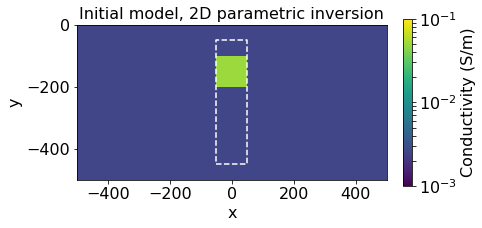

In [21]:
sigma= expmap * actmap *  parametric_block  * model[0]
fig = plt.figure(figsize=(5, 3))
out = mesh_2d.plotImage(sigma, pcolorOpts={'norm':LogNorm()}, clim=(1e-3, 1e-1))
cb = plt.colorbar(out[0], fraction=0.025)

plt.plot(xy_box[:,0], xy_box[:,1], 'w--')
plt.ylim(-500, 0.)
plt.gca().set_aspect(1)
plt.xlim(-500, 500)
plt.ylim(-500, 0)
cb.set_label('Conductivity (S/m)')
plt.title("Initial model, 2D parametric inversion", fontsize = 16)

fig.savefig('../figures/2Dparametric_startingmodel.png', dpi=350)

### Data fit

(1e-14, 3e-09)

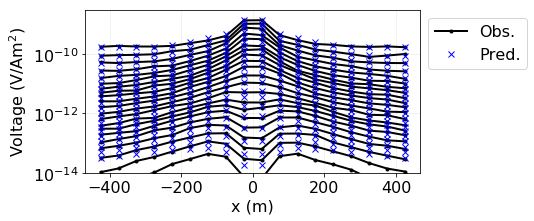

In [22]:
fig = plt.figure(figsize=(6, 3))
for itime in range(rx_z.times.size):
    plt.semilogy(x, -DOBS[:,0,itime], 'k.-', lw=2)
    plt.semilogy(x, -DPRED[:,itime], 'bx', lw=2)
plt.legend(("Obs.", "Pred."), bbox_to_anchor=(1,1))
plt.xlabel("x (m)")
plt.ylabel("Voltage (V/Am$^2$)")
plt.grid(which="both", alpha=0.2)
plt.ylim(1e-14, 3e-9)

### Figure used in abstract: starting model, recovered model, data fit and tikhonov curve

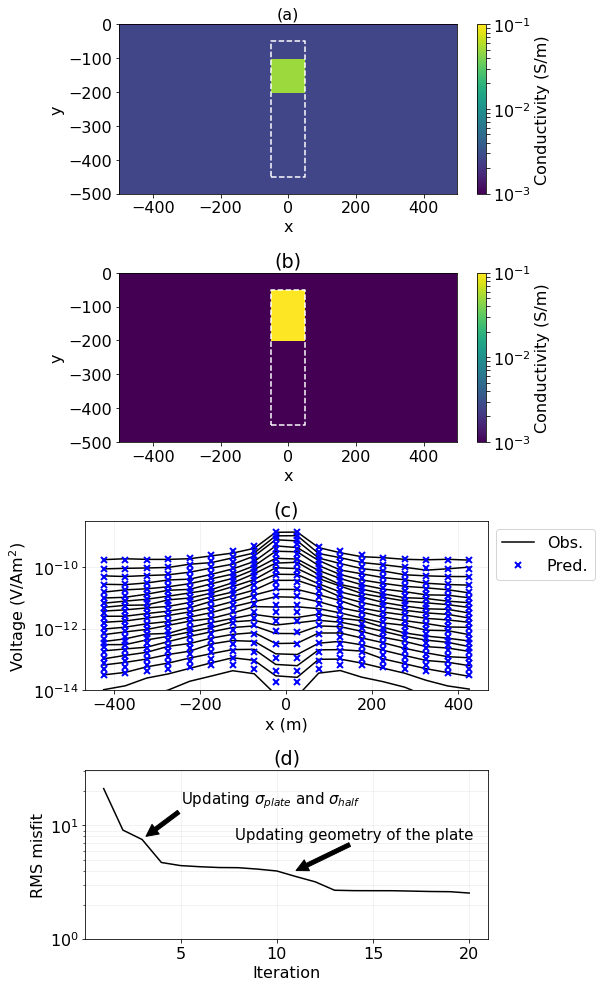

In [23]:
fig, ax = plt.subplots(4, 1, figsize=(8, 3.5*4))

sigma= expmap * actmap *  parametric_block  * model[-1]
sigma0= expmap * actmap *  parametric_block  * model[0]

out = mesh_2d.plotImage(sigma0, pcolorOpts={'norm':LogNorm()}, clim=(1e-3, 1e-1), ax=ax[0])
cb = plt.colorbar(out[0], fraction=0.025, ax=ax[0])
ax[0].plot(xy_box[:,0], xy_box[:,1], 'w--')
ax[0].set_ylim(-500, 0.)
ax[0].set_aspect(1)
ax[0].set_xlim(-500, 500)
ax[0].set_ylim(-500, 0)
cb.set_label('Conductivity (S/m)')
ax[0].set_title("(a)", fontsize = 16)

out = mesh_2d.plotImage(sigma, pcolorOpts={'norm':LogNorm()}, clim=(1e-3, 1e-1), ax=ax[1])
cb = plt.colorbar(out[0], fraction=0.025, ax=ax[1])
ax[1].set_ylim(-500, 0.)
ax[1].set_aspect(1)
ax[1].set_xlim(-500, 500)
ax[1].set_ylim(-500, 0)
cb.set_label('Conductivity (S/m)')
ax[1].set_title("(b)")
ax[1].plot(xy_box[:,0], xy_box[:,1], 'w--')


for itime in range(rx_z.times.size):
    ax[2].semilogy(x, -DOBS[:,0,itime], 'k-')
    ax[2].semilogy(x, -DPRED[:,itime], 'bx', markeredgewidth=2)
ax[2].legend(("Obs.", "Pred."), bbox_to_anchor=(1,1))

ax[2].set_xlabel("x (m)")
ax[2].set_ylabel("Voltage (V/Am$^2$)")
ax[2].grid(which="both", alpha=0.2)
ax[2].set_ylim(1e-14, 3e-9)
ax[2].set_title("(c)")

# ax_1 = ax[2].twinx()
ax[3].semilogy(results[:,0], np.sqrt(results[:,2]/ (survey.nD/2.)), 'k-')
# ax_1.plot(results[:,0], results[:,3], 'r-')
ax[3].set_xlabel("Iteration")
ax[3].set_ylabel("RMS misfit")
# ax_1.set_ylabel("Regularization", color='red')
# for tl in ax_1.get_yticklabels():
#     tl.set_color('r')
ax[3].grid(which='both', alpha=0.2)
ax[3].set_title("(d)")
ax[3].set_ylim([1, 3.1e1])

# ax_1 = ax[2].twinx()
# ax[2].text(6, np.sqrt(3e4/(survey.nD/2.)),"Updating $\sigma_{plate}$ and $\sigma_{half}$", fontsize=15)
# ax[2].text(8, np.sqrt(8e3/(survey.nD/2.)),"Updating geometry of the plate", fontsize=15)
# ax[2].arrow(5.5, 10, -2, -1.5, head_width=0.6, head_length=0.6, fc='k', ec='k')
# ax[2].arrow(13, 3, -2, -1.5, head_width=0.6, head_length=0.6, fc='k', ec='k')

ax[3].annotate(
    "Updating $\sigma_{plate}$ and $\sigma_{half}$", 
    xy=(3.2, 8), xytext=(5, 15.5), fontsize=15,
    arrowprops={'facecolor':'k', 'shrink':1},
#     verticalalignment='center'
)

ax[3].annotate(
    "Updating geometry of the plate", 
    xy=(11, 4), xytext=(14, 7.5), fontsize=15,
    arrowprops={'facecolor':'k', 'shrink':1},
    horizontalalignment='center'
#     verticalalignment='center'
)
# ax_1.set_ylim(0, 10)
# ax_1.set_yticks([])
plt.tight_layout()

fig.savefig('../figures/2Dparametric_inversion.png', dpi=350, bbox_inches="tight")

In [30]:
chi_fact = results[-1,2] / (survey.nD/2.)
rms = np.sqrt(chi_fact)
print (rms)
print (chi_fact)

2.5321216818392065
6.411640211640211
